In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load `Integral` and test it right away

In [2]:
require 'image'
local lena = image.lena():mean(1):squeeze()[{{1,4}, {1,4}}]

Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
require 'Integral-jit-multi'

-- compute true forward and backward results for some data
local intGold = Integral(16, 4, 4)
local params, gradParamsGold = intGold:getParameters()

local forwardGold = intGold:forward(lena)
local gradInputGold = intGold:backward(lena, forwardGold)

-- remove the old slow class
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil

-- require the new fast class
require 'Integral-cuda-multi'

local intTest = Integral(16, 4, 4):cuda()
local paramsTest, gradParamsTest = intTest:getParameters()

paramsTest:copy(params)
intTest:recalculateArea()

lena = lena:type(intTest:type())

-- compare results
local forwardTest = intTest:forward(lena)
local forwardErr = (forwardGold - forwardTest:float()):abs():sum() / 
                   forwardTest:nElement() / torch.abs(forwardGold):mean()
print('Output mean relative error:', forwardErr * 100 .. ' %')

local gradInputTest = intTest:backward(lena, forwardGold:type(intTest:type()))
local gradInputErr = (gradInputGold - gradInputTest:float()):abs():sum() / 
                     gradInputTest:nElement() / torch.abs(gradInputGold):mean()
print('gradInput mean relative error:', gradInputErr * 100 .. ' %')
local gradParamsErr = (gradParamsGold - gradParamsTest:float()):abs():sum() / 
                      gradParamsTest:nElement() / torch.abs(gradParamsGold):mean()
print('gradParams mean relative error:', gradParamsErr * 100 .. ' %')

assert(forwardErr    < 1e-6)
assert(gradInputErr  < 1e-6)
assert(gradParamsErr < 7e-4)

Output mean relative error:	1.3956582564299e-06 %	


gradInput mean relative error:	6.0973558033049e-07 %	
gradParams mean relative error:	2.8068720841962e-05 %	


### Test multi-channel vs single-channel `Integral`

Test forward pass

In [2]:
local nInputCh = 5
local nWindows = 7

require 'image'
torch.manualSeed(3)
local input = torch.rand(nInputCh, 234, 234)

Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
require 'Integral-jit-multi'

-- compute true forward result for some data
local intGold = Integral(nWindows, 234, 234)
local params, gradParamsGold = intGold:getParameters()

local forwardGold = torch.Tensor(nInputCh*nWindows, 234, 234)
for i = 1,nInputCh do
    forwardGold[{{(i-1)*nWindows+1, i*nWindows}}]:copy(intGold:forward(input[i]))
end

-- remove the single-channel class
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil

-- require the new multi-channel class
require 'Integral-cuda-multi'

local intTest = Integral(nWindows, 234, 234)
for i,member in ipairs{'xMin','xMax','yMin','yMax'} do
    intTest[member] = intGold[member]
end
intTest:recalculateArea()

local forwardTest = intTest:forward(input)

local forwardErr = (forwardGold - forwardTest):abs():sum() / 
                   forwardTest:nElement() / torch.abs(forwardGold):mean()
print('Output mean relative error:', forwardErr * 100 .. ' %')

./Integral-cuda-multi.lua:31: C/lib/libintegral-cuda.so: cannot open shared object file: No such file or directory
stack traceback:
	[C]: in function 'load'
	./Integral-cuda-multi.lua:31: in main chunk
	[C]: in function 'require'
	[string "local nInputCh = 5..."]:36: in main chunk
	[C]: in function 'xpcall'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:210: in function <...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:174>
	...ubb/Programs/Torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405e40: 

### Gradcheck

In [4]:
nParam = (not nParam or nParam == 5) and 1 or nParam + 1
print(nParam)

3	


In [5]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil
require 'IntegralSmartNorm'

Integral = IntegralSmartNorm

local nInputCh = 1
local nWindows = 1
local imSize = 6

torch.manualSeed(666)
input = image.convolve(torch.rand(nInputCh, imSize, imSize):pow(3), 
                                image.gaussian(math.max(1,imSize/3)), 'same')
input:add(-input:mean())

target = image.convolve(torch.rand(nInputCh*nWindows, imSize, imSize):pow(3), 
                                image.gaussian(math.max(1,imSize/3)), 'same')
target:add(-target:mean())

int = Integral(nWindows, imSize, imSize)
int.exact = true
int.smart = true

net = int
int.xMin[1] = 0
int.xMax[1] = 0
int.yMin[1] = 0
int.yMax[1] = 0

-- int.xMin[2] = -0.9
-- int.xMax[2] = 1.75
-- int.yMin[2] = -0.2
-- int.yMax[2] = -0.4

-- require 'nn'
-- net = nn.Sequential()
-- net:add(int)
-- net:add(nn.SpatialConvolutionMM(nInputCh*nWindows, 8, 1, 1, 1, 1)) 
-- net:add(nn.LeakyReLU(0.01))
-- net:add(Integral(4, imSize, imSize))
-- net:add(nn.SpatialConvolutionMM(3*4, 8, 1, 1, 1, 1))
-- net:add(nn.Reshape(8, imSize*imSize))
-- net:add(nn.Transpose({2, 1}))

-- target = torch.IntTensor(imSize*imSize)
-- target:apply(function() return torch.random(8) end)

crit = nn.MSECriterion()
-- crit = nn.CrossEntropyCriterion()

param = {}
loss = {}
dL_dParam_nn = {}
dL_dParam_diff = {}

-- nParam = 1 -- 1,2,3,4 <-> xMax,yMax,xMin,yMin

if -- ***********************
nParam == 1 then int.xMax[1] = imSize*2 elseif
nParam == 2 then int.yMax[1] = imSize*2 elseif
nParam == 3 then int.xMin[1] = -1 elseif -- -imSize*2 elseif
nParam == 4 then int.yMin[1] = -imSize*2 end

-- int:recalculateArea()

local stepSize = 0.02
local maxStep = 100
local innerStepSize = 0.01

for i = 1,maxStep do
    if -- ***************************
    nParam == 1 then param[i] = int.xMax[1] + stepSize * (-maxStep+i) elseif
    nParam == 2 then param[i] = int.yMax[1] + stepSize * (-maxStep+i) elseif
    nParam == 3 then param[i] = int.xMin[1] + stepSize * (i-1) elseif
    nParam == 4 then param[i] = int.yMin[1] + stepSize * (i-1) elseif
    nParam == 5 then param[i] = -100 + i*stepSize end
    
    loss[i] = -666
    dL_dParam_nn[i] = -666
    dL_dParam_diff[i] = -666
end

for i = 1,#param do
    net:zeroGradParameters()
    
    if -- ***************************
    nParam == 1 then int.xMin[1] = param[i] elseif
    nParam == 2 then int.yMin[1] = param[i] elseif
    nParam == 3 then int.xMax[1] = param[i] elseif
    nParam == 4 then int.yMax[1] = param[i] elseif
    nParam == 5 then input[{1,1,1}] = param[i] end
    
--     int:recalculateArea()
    
    pred = net:forward(input)    
    currLoss = crit:forward(pred, target)
    dLoss_dOutput = crit:backward(pred, target)
--     net:backward(input, dLoss_dOutput)
    net:updateGradInput(input, dLoss_dOutput)
    if i >= 1 and i <= 2 then
        print('input:')
        print(input)
        print('pred:')
        print(pred)
        print('outputOnes:')
        print(int.outputOnes)
        print('gradOut by INonNorm:')
        print(int.cdiv.gradInput[1])
        print('gradOut by 1-s:')
        print(int.cdiv.gradInput[2])
    end
    net:accGradParameters(input, dLoss_dOutput, 1)
    if i >= 1 and i <= 2 then
        print('gradOut by INonNorm multipliers:')
        print(int.cdiv.gradInput[1])
        print('gradOut by 1-s multipliers:')
        print(int.cdiv.gradInput[2])
        print('Manual deriv = ' .. int.gradXMin[1])
    end
    
    loss[i] = currLoss
    
    if -- ***************************
    nParam == 1 then dL_dParam_nn[i] = int.gradXMin[1] elseif
    nParam == 2 then dL_dParam_nn[i] = int.gradYMin[1] elseif
    nParam == 3 then dL_dParam_nn[i] = int.gradXMax[1] elseif
    nParam == 4 then dL_dParam_nn[i] = int.gradYMax[1] elseif
    nParam == 5 then dL_dParam_nn[i] = int.gradInput[{1,1,1}] end
    
    -- step forward a bit
    if -- ***************************
    nParam == 1 then int.xMin[1] = param[i] + innerStepSize elseif
    nParam == 2 then int.yMin[1] = param[i] + innerStepSize elseif
    nParam == 3 then int.xMax[1] = param[i] + innerStepSize elseif
    nParam == 4 then int.yMax[1] = param[i] + innerStepSize elseif
    nParam == 5 then input[{1,1,1}] = param[i] + innerStepSize end
    
--     int:recalculateArea()
    
    pred = net:forward(input)
    currLoss = crit:forward(pred, target)
    dLoss_dOutput = crit:backward(pred, target)
    gradInput = net:backward(input, dLoss_dOutput)
    
    dL_dParam_diff[i] = (currLoss - loss[i]) / innerStepSize
    
    collectgarbage()
    
    if i % 50 == 0 then print(i) end
end

for i = 1,#param-1 do
--     dL_dParam_diff[i] = (loss[i+1] - loss[i]) / stepSize
end

param[#param] = nil
dL_dParam_nn[#dL_dParam_nn] = nil
dL_dParam_diff[#dL_dParam_diff] = nil
loss[#loss] = nil

input:	
(1,.,.) = 
 -0.1062 -0.1058 -0.0109 -0.0078 -0.1152 -0.1179
  0.0357  0.1915  0.4614  0.3230 -0.1013 -0.1126
 -0.0647  0.0971  0.2461  0.1064 -0.2101 -0.1904
 -0.1584 -0.1472 -0.2185 -0.0554  0.0936  0.1586
 -0.1817 -0.1540 -0.0753  0.0747  0.1059  0.1324
 -0.0591  0.1099  0.0630  0.0497 -0.0671  0.0108
[torch.FloatTensor of size 1x6x6]

pred:	
(1,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 -0.1062 -0.1058 -0.0109 -0.0078 -0.1152 -0.1179
  0.0357  0.1915  0.4614  0.3230 -0.1013 -0.1126
 -0.0647  0.0971  0.2461  0.1064 -0.2101 -0.1904
 -0.1584 -0.1472 -0.2185 -0.0554  0.0936  0.1586
 -0.1817 -0.1540 -0.0753  0.0747  0.1059  0.1324
[torch.FloatTensor of size 1x6x6]

outputOnes:	
(1,.,.) = 
  100  100  100  100  100  100
    1    1    1    1    1    1
    1    1    1    1    1    1
    1    1    1    1    1    1
    1    1    1    1    1    1
    1    1    1    1    1    1
[torch.FloatTensor of size 1x6x6]

gradOut by INonNorm:	


(1,.,.) = 
 0.01 *
   0.0182  0.0090  0.0087  0.0002  0.0005  0.0177
   0.4435 -1.7233 -0.5184 -0.1900 -0.6911 -0.5104
  -0.3016 -0.7338  1.0938  1.2406  0.5528 -2.4507
  -0.1086  0.7374  0.8163 -0.2446 -0.0624 -1.5352
  -0.5281 -0.5315 -0.3655  0.4412  0.9849  1.2626
  -0.9576 -1.7426 -0.1850  0.8600 -0.2767 -0.8010
[torch.FloatTensor of size 1x6x6]

gradOut by 1-s:	
(1,.,.) = 
 0.001 *
  -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000
   0.4710 -1.8234 -0.0565 -0.0149 -0.7965 -0.6020
   0.1075  1.4049 -5.0463 -4.0070  0.5600 -2.7586
  -0.0703 -0.7161 -2.0092  0.2603 -0.1311 -2.9233
  -0.8363 -0.7825 -0.7986  0.2445 -0.9215 -2.0027
  -1.7404 -2.6829 -0.1392 -0.6421  0.2931  1.0609
[torch.FloatTensor of size 1x6x6]



gradOut by INonNorm multipliers:	
(1,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.1062  0.1058  0.0109  0.0078  0.1152  0.1179
 -0.0357 -0.1915 -0.4614 -0.3230  0.1013  0.1126
  0.0647 -0.0971 -0.2461 -0.1064  0.2101  0.1904
  0.1584  0.1472  0.2185  0.0554 -0.0936 -0.1586
[torch.FloatTensor of size 1x6x6]

gradOut by 1-s multipliers:	
(1,.,.) = 
  0  0  0  0  0  0
  0  0  0  0  0  0
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
[torch.FloatTensor of size 1x6x6]

Manual deriv = 0.017601555213332	


input:	
(1,.,.) = 
 -0.1062 -0.1058 -0.0109 -0.0078 -0.1152 -0.1179
  0.0357  0.1915  0.4614  0.3230 -0.1013 -0.1126
 -0.0647  0.0971  0.2461  0.1064 -0.2101 -0.1904
 -0.1584 -0.1472 -0.2185 -0.0554  0.0936  0.1586
 -0.1817 -0.1540 -0.0753  0.0747  0.1059  0.1324
 -0.0591  0.1099  0.0630  0.0497 -0.0671  0.0108
[torch.FloatTensor of size 1x6x6]

pred:	


(1,.,.) = 
 -0.1062 -0.1058  0.0000  0.0000 -0.1152 -0.1179
 -0.1034 -0.1000 -0.0016 -0.0013 -0.1150 -0.1178
  0.0337  0.1896  0.4571  0.3187 -0.1034 -0.1141
 -0.0666  0.0923  0.2370  0.1032 -0.2042 -0.1836
 -0.1588 -0.1473 -0.2157 -0.0529  0.0938  0.1581
 -0.1793 -0.1488 -0.0725  0.0742  0.1025  0.1301
[torch.FloatTensor of size 1x6x6]

outputOnes:	


(1,.,.) = 
  0.0200  0.0200  0.0200  0.0200  0.0200  0.0200
  1.0200  1.0200  1.0200  1.0200  1.0200  1.0200
  1.0200  1.0200  1.0200  1.0200  1.0200  1.0200
  1.0200  1.0200  1.0200  1.0200  1.0200  1.0200
  1.0200  1.0200  1.0200  1.0200  1.0200  1.0200
  1.0200  1.0200  1.0200  1.0200  1.0200  1.0200
[torch.FloatTensor of size 1x6x6]

gradOut by INonNorm:	
(1,.,.) = 
  0.6149  0.1542  0.4339  0.0107 -0.2940  0.5585
  0.0045 -0.0166 -0.0046 -0.0015 -0.0068 -0.0050
 -0.0031 -0.0073  0.0105  0.0119  0.0053 -0.0241
 -0.0012  0.0070  0.0075 -0.0026 -0.0003 -0.0147
 -0.0052 -0.0052 -0.0034  0.0045  0.0097  0.0124
 -0.0093 -0.0168 -0.0017  0.0084 -0.0029 -0.0080
[torch.FloatTensor of size 1x6x6]

gradOut by 1-s:	
(1,.,.) = 
 0.01 *
   6.5305  1.6312 -0.0000 -0.0000 -3.3877  6.5869
   0.0465 -0.1657 -0.0008 -0.0002 -0.0777 -0.0589
   0.0103  0.1383 -0.4797 -0.3803  0.0549 -0.2751
  -0.0078 -0.0643 -0.1779  0.0265 -0.0059 -0.2695
  -0.0826 -0.0769 -0.0740  0.0236 -0.0907 -0.1953
  -0.1660 -0

gradOut by INonNorm multipliers:	
(1,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.1062  0.1058  0.0109  0.0078  0.1152  0.1179
 -0.0357 -0.1915 -0.4614 -0.3230  0.1013  0.1126
  0.0647 -0.0971 -0.2461 -0.1064  0.2101  0.1904
  0.1584  0.1472  0.2185  0.0554 -0.0936 -0.1586
[torch.FloatTensor of size 1x6x6]

gradOut by 1-s multipliers:	
(1,.,.) = 
  0  0  0  0  0  0
  0  0  0  0  0  0
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
[torch.FloatTensor of size 1x6x6]

Manual deriv = 0.016725638881326	


50	


100	


In [38]:
require 'gnuplot'

gnuplot.figure(4)
gnuplot.plot{
--     {'manual', torch.Tensor(param), torch.Tensor(dL_dParam_nn), '-'},
--     {'diff'  , torch.Tensor(param), torch.Tensor(dL_dParam_diff), '-'},
--     {'zero'  , torch.Tensor{0, 0}, torch.Tensor{torch.Tensor(dL_dParam_diff):min(), torch.Tensor(dL_dParam_diff):max()}, '-'},
    {'loss'  , torch.Tensor(param), torch.Tensor(loss), '-'},
}
gnuplot.movelegend('right', 'middle')
gnuplot.xlabel('parameter')
gnuplot.ylabel('dLoss / dParameter')

In [27]:
function round_down(x)
    local rounded = math.floor(x)
    return rounded, x-rounded -- return integer and fractional parts
end

function round_up(x)
    local rounded = math.ceil(x)
    return rounded, rounded-x -- return integer and fractional parts
end

In [24]:
require 'image'
local img = image.scale(image.lena():mean(1):squeeze(), 6, 6)

int = Integral(1, img:size(1), img:size(2))
int.exact = true
int.smart = true
int.xMin[1] = 3
int.xMax[1] = 5
int.yMin[1] = 3
int.yMax[1] = 5

int:zeroGradParameters()
pred = int:forward(img)
loss = crit:forward(pred, img*2)
gradOutput = crit:backward(pred, img)
int:backward(img, gradOutput)
print('Manual deriv = ' .. int.gradXMax[1])

local stepSize = 0.01
int.xMax[1] = int.xMax[1] + stepSize
loss_step = crit:forward(int:forward(img), img*2)
print('Diff deriv = ' .. (loss_step - loss) / stepSize)

Manual deriv = 0	


Diff deriv = 0	


In [79]:
int.outputOnes

(1,.,.) = 
  1.5100  1.5100  1.5100  1.5100  1.5100  1.5100
  1.5100  1.5100  1.5100  1.5100  1.5100  1.5100
  1.5100  1.5100  1.5100  1.5100  1.5100  1.5100
  1.5100  1.5100  1.5100  1.5100  1.5100  1.5100
  1.5100  1.5100  1.5100  1.5100  1.5100  1.5100
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
[torch.FloatTensor of size 1x6x6]



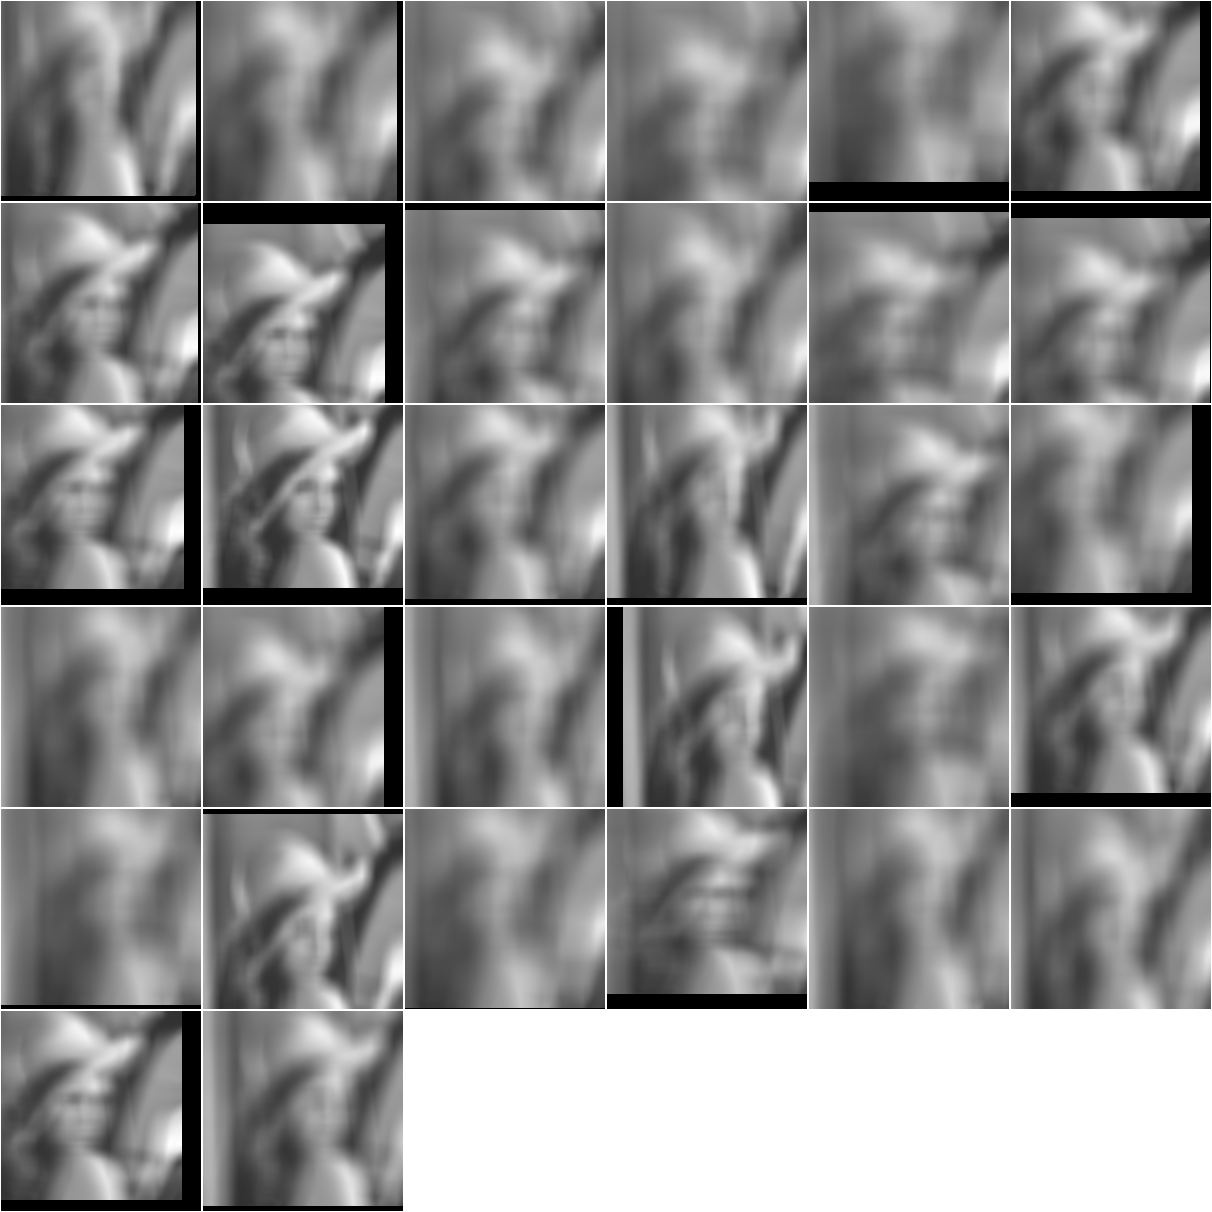

In [44]:
require 'image'
local img = image.scale(image.lena():mean(1):squeeze(), 200, 200)

-- img = torch.rand(3, 3)

-- torch.manualSeed(660)
int = Integral(32, img:size(1), img:size(2))
int.exact = true
-- int.xMin[1] = 0
-- int.xMax[1] = 0
-- int.yMin[1] = 0.5
-- int.yMax[1] = 0.5

-- print(img)
-- print(int:forward(img)[7][{{1, 30}, {194, 200}}])
-- print(int.outputOnes[7][{{1, 30}, {194, 200}}])
-- print(int.outputNonNorm[7][{{1, 30}, {194, 200}}][{{}, {4,-1}}])
itorch.image(int:forward(img))

### Measure execution times

Input: 1024x768 image

* **Forward** experiment: compute `16x1024x768` feature maps 4 times
* **Backward** experiment: do a backprop step (from the "after `Forward`" state) 4 times

#### Forward

* $2.993 \pm 0.242$ sec. (LuaJIT loop + exact fractional parts computation)	
* $0.487 \pm 0.087$ sec. (LuaJIT loop)
* $0.358 \pm 0.019$ sec. (C loop)
* $0.321 \pm 0.037$ sec. (+ precomputed `t,b,l,r`)
* $0.165 \pm 0.058$ sec. (+ parallel)
* $0.140 \pm 0.066$ sec. (+ inline `areaCoeff` multiplication)
* $0.048 \pm 0.032$ sec. (after GPU modifications, i dunno why lol)

*CUDA, GTX 970*

* $0.03152 \pm 0.0084$ sec. ('single' kernel)
* $0.03481 \pm 0.0081$ sec. ('multi' kernel, block size = 1x32x32)
* $0.08079 \pm 0.0123$ sec. ('multi' kernel, block size = 4x16x16)

#### Backward

* $2.660 \pm 0.252$ sec. (LuaJIT)
* $1.956 \pm 0.385$ sec. (C parallel `updGI`)
* $1.616 \pm 0.274$ sec. (+ C gradParam loop, precomputed `t,b,l,r`)
* $1.357 \pm 0.136$ sec. (+ parallelize by deltas -- 2 threads)
* $1.991 \pm 0.358$ sec. (+ parallelize by deltas -- 4 threads)
* $1.576 \pm 0.290$ sec. (+ parallelize by rows)
* $1.103 \pm 0.179$ sec. (after GPU modifications, i dunno why lol)

*CUDA, GTX 970*

* $0.5923 \pm 0.0413$ sec. (parallelized only `forward` (*affects `updateGradInput`*) with 'multi' kernel, block size = 1x32x32)
* $0.3409 \pm 0.0144$ sec. (+ parallel `backward`, 'single' kernel)

In [68]:
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
require 'Integral-cuda-multi'

./Integral-cuda-multi.lua:31: C/lib/libintegral-cuda.so: cannot open shared object file: No such file or directory
stack traceback:
	[C]: in function 'load'
	./Integral-cuda-multi.lua:31: in main chunk
	[C]: in function 'require'
	[string "Integral = nil..."]:8: in main chunk
	[C]: in function 'xpcall'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:210: in function <...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:174>
	...ubb/Programs/Torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405e40: 

In [5]:
h = 768
w = 1024
nMaps = 16

In [6]:
int = Integral(nMaps, h, w):cuda()
params, gradParams = int:getParameters()

#### Forward experiment

In [7]:
img = torch.rand(h, w):type(int:type())
local repeats = 4
local timeRepeats = 20

int:forward(img)

times = torch.Tensor(timeRepeats)

for timeRepeat = 1,timeRepeats do

    local timer = torch.Timer()

    for _ = 1,repeats do
        int:forward(img)
    end

    cutorch.synchronize()
    timer:stop()

    times[timeRepeat] = timer:time().real
    
    collectgarbage()
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.03714292049408 +/- 0.012073122348821 seconds	


#### Backward experiment

In [12]:
img = torch.rand(h, w):type(int:type())
local repeats = 4
local timeRepeats = 15

times = torch.Tensor(timeRepeats)

local prediction = int:forward(img)
int:backward(img, prediction)

for timeRepeat = 1,timeRepeats do

    local timer = torch.Timer()

    for _ = 1,repeats do
        int:backward(img, prediction)
    end

    cutorch.synchronize()
    timer:stop()

    times[timeRepeat] = timer:time().real
    
    collectgarbage()
    
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.34089180628459 +/- 0.014416537071796 seconds	
